# Post-Processed Fair Predictors: Real data analysis

This notebook accompanies the following paper:

Alan Mishler, Edward H. Kennedy, and Alexandra Chouldechova. **Fairness in Risk Assessment Instruments: Post-Processing to Achieve Counterfactual Equalized Odds**. 2021.  In Proceedings of the 2021 ACM Conference on Fairness, Accountability, and Transparency (FAccT '21). Association for Computing Machinery, New York, NY, USA, 386–400. https://doi.org/10.1145/3442188.3445902

It illustrates analysis of the COMPAS dataset. Analysis of the child welfare dataset is not included because that data is not publicly available.

In [131]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from patsy import dmatrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split

from counterfactualEO.functions_estimation import fair_derived_crossfit
from counterfactualEO.functions_evaluation import (
    metrics_post_crossfit,
    add_reference_values
)
from counterfactualEO.functions_plotting import plot_metrics

In [ ]:
## Set aesthetics for plots

mpl.rcdefaults()
sns.reset_defaults()
sns.set_theme(style='ticks', context='notebook')

## Make sure tick marks are visible
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['ytick.left'] = True
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'

# Add gridlines explicitly for both axes
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.axis'] = 'both'
mpl.rcParams['axes.grid.which'] = 'major'
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['grid.color'] = '0.9'
mpl.rcParams['grid.alpha'] = 1.0

In [190]:
%matplotlib inline

In [ ]:
# Paths to save data and figures

OUTPATH = '../outputs'
FIGPATH = '../figures'

# COMPAS

## Load and preprocess data

In [ ]:
# Load the dataset
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df = pd.read_csv(url)

# Select relevant columns
df = df[[
    'id', 'age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex',
    'priors_count', 'days_b_screening_arrest', 'decile_score',
    'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out'
]]

# Apply filters
df = df[
    (df['days_b_screening_arrest'] <= 30) &
    (df['days_b_screening_arrest'] >= -30) &
    (df['is_recid'] != -1) &
    (df['c_charge_degree'] != "O") &
    (df['score_text'] != 'N/A') &
    (df['race'].isin(["African-American", "Caucasian"]))
].copy()

# Feature engineering
df['score_factor'] = np.where(df['score_text'] == "Low", "LowScore", "HighScore")
df['score_decile'] = df['decile_score'] / 10
jail_in = pd.to_datetime(df['c_jail_in']).dt.floor('D')
jail_out = pd.to_datetime(df['c_jail_out']).dt.floor('D')
df['incarceration_duration'] = (jail_out - jail_in).dt.days

# Recode categorical variables
df['age_factor'] = pd.Categorical(df['age_cat'],
                                  categories=["Less than 25", "25 - 45", "Greater than 45"],
                                  ordered=True)
df['race_factor'] = pd.Categorical(df['race'], categories=["African-American", "Caucasian"])
df['gender_factor'] = pd.Categorical(df['sex'], categories=["Male", "Female"])
df['crime_factor'] = pd.Categorical(df['c_charge_degree'], categories=['F', 'M'])
df['score_factor'] = pd.Categorical(df['score_factor'], categories=["LowScore", "HighScore"])

# One-hot encode with standard dummy coding
categorical_vars = ['race_factor', 'gender_factor', 'age_factor', 'crime_factor', 'score_factor']
dummies = pd.get_dummies(df[categorical_vars], drop_first=True).astype(int)

# Rename columns to match R naming
rename_map = {
    'race_factor_Caucasian': 'race',
    'gender_factor_Female': 'gender',
    'age_factor_25 - 45': 'age_25_to_45',
    'age_factor_Greater than 45': 'age_greater_than_45',
    'crime_factor_M': 'crime_factor',
    'score_factor_HighScore': 'score_factor'
}
dummies.rename(columns=rename_map, inplace=True)

# Combine with numeric features
numeric_vars = ['priors_count', 'score_decile', 'incarceration_duration', 'two_year_recid']
numeric_data = df[numeric_vars]

# Final combined matrix
dat = pd.concat([df[['id']], dummies, numeric_data], axis=1)
dat['released'] = (df['incarceration_duration'] <= 3).astype(int)

# Reorder columns
final_columns = ['id', 'race', 'gender', 'age_greater_than_45', 'age_25_to_45',
                 'priors_count', 'crime_factor', 'score_factor', 'score_decile',
                 'incarceration_duration', 'two_year_recid', 'released']
dat = dat[final_columns]

dat = dat.reset_index(drop=True)

## Analysis Setup

In [ ]:
train, test = train_test_split(dat, test_size = 0.5)

In [98]:
random_state = 104
epsilons = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

A = 'race'
X = ['age_25_to_45', 'age_greater_than_45', 'priors_count']
R = 'score_factor'
D = 'released'
Y = 'two_year_recid'

learner_pi = RandomForestClassifier(n_estimators=200, min_samples_leaf=10, max_features='sqrt')
learner_mu = RandomForestClassifier(n_estimators=200, min_samples_leaf=10, max_features='sqrt')

## Metrics for COMPAS before post-processing

In [ ]:
res_in = metrics_post_crossfit([0, 1, 0, 1], test, A, X, R, D, Y, learner_pi,
                 learner_mu, n_splits=5, random_state = random_state)
res_in.to_csv(os.path.join(OUTPATH, 'metrics_input.csv'), index = False)
print(res_in)

        metric     value  ci_lower  ci_upper
0         risk  0.354334  0.314814  0.395948
1  risk_change  0.000000  0.000000  0.000000
2         FPR0  0.430713  0.365725  0.498178
3         FPR1  0.195445  0.140111  0.265875
4      gap_FPR  0.235268  0.141886  0.324499
5         FNR0  0.326864  0.279422  0.378134
6         FNR1  0.488355  0.419520  0.557635
7      gap_FNR -0.161491 -0.246456 -0.074062
8  pred_change  0.000000  0.000000  0.000000


## Post-processed predictors

In [ ]:
theta_arr = []
res_arr = []

for val in epsilons:
    print('Estimating theta* for epsilon_pos = epsilon_neg = {}'.format(val))
    out = fair_derived_crossfit(train, A, X, R, D, Y, learner_pi, learner_mu,
                          val, val, outcome='phihat',
                          n_splits=5, estimator_type='pooled',
                          trunc_pi=0.975, random_state=random_state)
    theta = out['theta']
    theta_arr.append(theta)
    res = metrics_post_crossfit(theta, test, A, X, R, D, Y, learner_pi,
                             learner_mu, n_splits=5, random_state = random_state)
    res_arr.append(res)

Estimating theta* for epsilon_pos = epsilon_neg = 0
Estimating theta* for epsilon_pos = epsilon_neg = 0.01
Estimating theta* for epsilon_pos = epsilon_neg = 0.05
Estimating theta* for epsilon_pos = epsilon_neg = 0.1
Estimating theta* for epsilon_pos = epsilon_neg = 0.2
Estimating theta* for epsilon_pos = epsilon_neg = 0.3
Estimating theta* for epsilon_pos = epsilon_neg = 0.4
Estimating theta* for epsilon_pos = epsilon_neg = 0.5
Estimating theta* for epsilon_pos = epsilon_neg = 0.6
Estimating theta* for epsilon_pos = epsilon_neg = 0.7
Estimating theta* for epsilon_pos = epsilon_neg = 0.8
Estimating theta* for epsilon_pos = epsilon_neg = 0.9
Estimating theta* for epsilon_pos = epsilon_neg = 1.0


In [ ]:
## Combine results and add reference values for plain COMPAS, the input predictor
res = pd.concat(res_arr, keys=epsilons)
res = res.reset_index().drop(columns = 'level_1').rename(
    columns = {'level_0': 'epsilon'})
res = add_reference_values(res, res_in)

res.to_csv(os.path.join(OUTPATH, 'metrics_post-processed.csv'), index = False)
pd.DataFrame(theta_arr).to_csv(os.path.join(OUTPATH, 'theta_array.csv'), index = False)

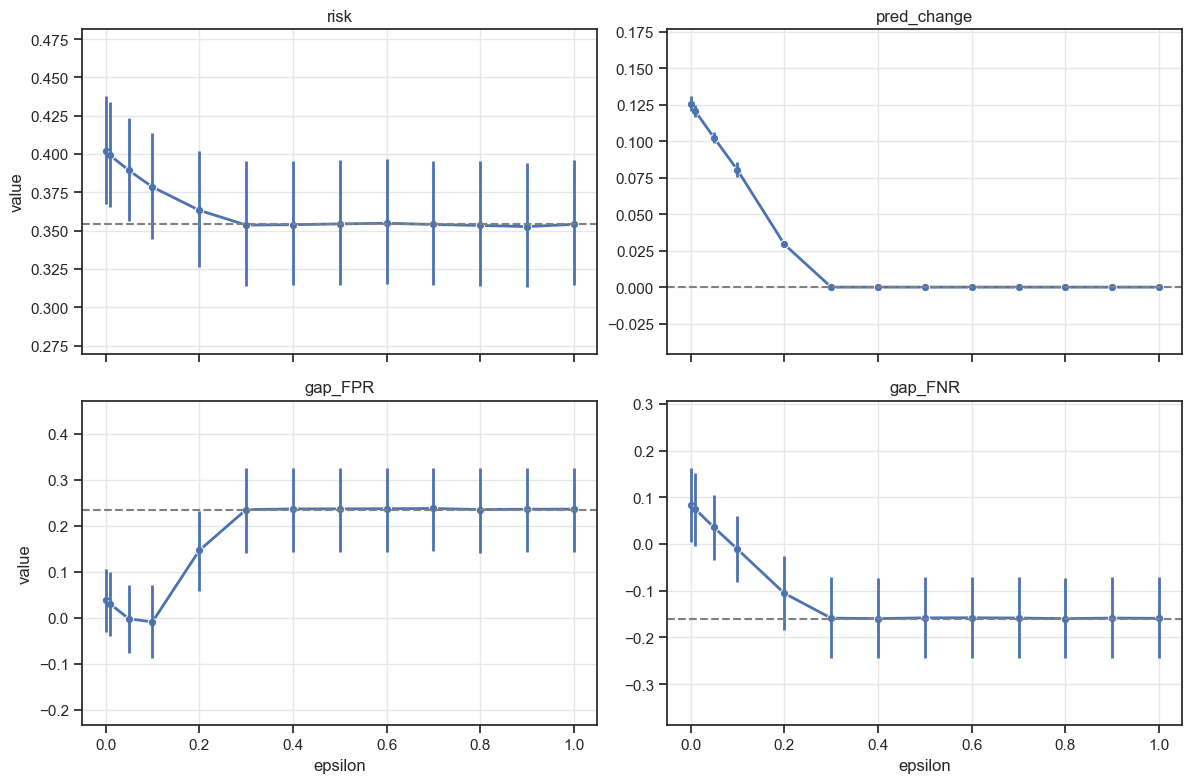

In [ ]:
## Plot results with reference lines for COMPAS
plot_metrics(res, x='epsilon', y='value', row=None, col='metric',
              col_order=['risk', 'pred_change', 'gap_FPR', 'gap_FNR'],
              reference_col='reference_value', centered=False,
              draw_custom_errorbars=True, max_ticks=6, 
              categorical_x=False, height=4, aspect=1.5, col_wrap=2)